In [18]:
import pandas as pd
import numpy as np
from IPython.display import display

# Listing down tokens to look out for
MISSING_TOKENS = ["?", "NA", "N/A", "", " ", "null", "None", "none", "NULL", "NaN", "nan"]

# Creating funtion for quick summary that shows how many missing values we have and its percentage 
def missing_summary(df):
    miss_count = df.isna().sum()
    miss_pct = (df.isna().mean() * 100).round(2)
    summary = pd.DataFrame({"missing_count": miss_count, "missing_pct": miss_pct})
    return summary.sort_values("missing_count", ascending=False)

# Function to clean out rows, making sure there are no unneccesary spaces or charachters
def clean_surface(df):
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip()
    df = df.replace(MISSING_TOKENS, np.nan)

    tokens_lower = {t.strip().lower() for t in MISSING_TOKENS}
    for c in df.select_dtypes(include=["object", "string"]).columns:
        s = df[c].astype("string").str.strip()
        df[c] = s
        df.loc[df[c].str.lower().isin(tokens_lower), c] = np.nan
    return df

#Cleans out duplicates by keeping the first data that shows up
def smart_dedupe(df):
    df = df.copy()
    id_cols = [c for c in df.columns if "id" in c.lower()]
    for c in id_cols:
        before = len(df)
        df = df.drop_duplicates(subset=[c], keep="first")
        if len(df) < before:
            return df
    return df.drop_duplicates()

#Coerces data that have the same data across other 3 files
def coerce_dates(df):
    df = df.copy()
    date_cols = [c for c in df.columns if "date" in c.lower()]
    for c in date_cols:
        df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def coerce_numerics(df):
    df = df.copy()
    # numeric-like columns by common keywords 
    for c in df.columns:
        cl = c.lower()
        if any(k in cl for k in ["amount", "sales", "price", "cost", "qty", "quantity", "score", "rating", "units"]):
            s = df[c].astype("string").str.replace(",", "", regex=False)
            s = s.str.replace("₱", "", regex=False).str.replace("$", "", regex=False)
            df[c] = pd.to_numeric(s, errors="coerce")
    return df

# Makes sure all strings or objects are the same format
def standardize_categories(df):
    df = df.copy()
    for c in df.select_dtypes(include=["object", "string"]).columns:
        # keep it simple: strip and title-case short category-like fields
        if df[c].nunique(dropna=True) <= max(50, int(0.2 * len(df))):
            df[c] = df[c].astype("string").str.strip()
    return df

# Fills missing values with median
def fill_missing_baseline(df):
    df = df.copy()
    # numeric -> median
    for c in df.select_dtypes(include=["number"]).columns:
        df[c] = df[c].fillna(df[c].median())
    # categorical -> mode (skip likely free-text columns)
    skip_keywords = ["comment", "comments", "message", "review", "text", "description", "remarks", "notes"]
    for c in df.select_dtypes(include=["object", "string"]).columns:
        if any(k in c.lower() for k in skip_keywords):
            continue
        if df[c].isna().any():
            mode_val = df[c].mode(dropna=True)
            if len(mode_val) > 0:
                df[c] = df[c].fillna(mode_val.iloc[0])
    return df


In [23]:
# Load all 3 CSV files (we always work with all 3 datasets)
transactions_raw = pd.read_csv("Transaction_Data.csv", dtype="string")
feedback_raw     = pd.read_csv("Customer_Feedback_Data.csv", dtype="string")
products_raw     = pd.read_csv("Product_Offering_Data.csv", dtype="string")

# Fix decimal-comma scores: e.g., "5,1" should become 5.1 (NOT 51)
def parse_decimal_comma(series):
    s = series.astype("string").str.strip()
    s = s.str.replace(",", ".", regex=False)   # treat comma as decimal separator
    return pd.to_numeric(s, errors="coerce")

for df in [transactions_raw, feedback_raw]:
    for col in ["Satisfaction_Score", "Likelihood_to_Recommend"]:
        if col in df.columns:
            df[col] = parse_decimal_comma(df[col])

print("RAW SHAPES")
print("Transactions:", transactions_raw.shape)
print("Feedback:    ", feedback_raw.shape)
print("Products:    ", products_raw.shape)

# Clean pipeline for each dataset
def week2_clean(df):
    df = clean_surface(df)
    df = smart_dedupe(df)
    df = coerce_dates(df)
    df = coerce_numerics(df)
    df = standardize_categories(df)
    return df

transactions = week2_clean(transactions_raw)
feedback     = week2_clean(feedback_raw)
products     = week2_clean(products_raw)

# Dataset-specific missing handling (simple + explainable)
if "Transaction_Amount" in transactions.columns:
    transactions["Amount_Was_Missing"] = transactions["Transaction_Amount"].isna()
    if "Transaction_Type" in transactions.columns:
        type_medians = transactions.groupby("Transaction_Type")["Transaction_Amount"].median()
        transactions["Transaction_Amount"] = transactions["Transaction_Amount"].fillna(
            transactions["Transaction_Type"].map(type_medians)
        )
    transactions["Transaction_Amount"] = transactions["Transaction_Amount"].fillna(
        transactions["Transaction_Amount"].median()
    )

if "Satisfaction_Score" in feedback.columns:
    feedback["Score_Was_Missing"] = feedback["Satisfaction_Score"].isna()
    feedback["Satisfaction_Score"] = feedback["Satisfaction_Score"].fillna(
        feedback["Satisfaction_Score"].median()
    )

# Baseline filling for remaining missing values
transactions = fill_missing_baseline(transactions)
feedback     = fill_missing_baseline(feedback)
products     = fill_missing_baseline(products)

# If an age group column exists, fill remaining with "Unknown"
age_cols = [c for c in products.columns if "age" in c.lower() and "group" in c.lower()]
if age_cols:
    products[age_cols[0]] = products[age_cols[0]].fillna("Unknown")

print("\nCLEANED SHAPES")
print("Transactions:", transactions.shape)
print("Feedback:    ", feedback.shape)
print("Products:    ", products.shape)

print("\nTOP MISSING (AFTER CLEANING) - Transactions")
display(missing_summary(transactions).head(10))
print("\nTOP MISSING (AFTER CLEANING) - Feedback")
display(missing_summary(feedback).head(10))
print("\nTOP MISSING (AFTER CLEANING) - Products")
display(missing_summary(products).head(10))


RAW SHAPES
Transactions: (5050, 5)
Feedback:     (5050, 4)
Products:     (15, 6)

CLEANED SHAPES
Transactions: (5000, 6)
Feedback:     (1000, 5)
Products:     (10, 6)

TOP MISSING (AFTER CLEANING) - Transactions


,missing_count,missing_pct
Transaction_ID,0,0.0
Customer_ID,0,0.0
Transaction_Date,0,0.0
Transaction_Amount,0,0.0
Transaction_Type,0,0.0
Amount_Was_Missing,0,0.0



TOP MISSING (AFTER CLEANING) - Feedback


,missing_count,missing_pct
Customer_ID,0,0.0
Satisfaction_Score,0,0.0
Feedback_Comments,0,0.0
Likelihood_to_Recommend,0,0.0
Score_Was_Missing,0,0.0



TOP MISSING (AFTER CLEANING) - Products


,missing_count,missing_pct
Product_ID,0,0.0
Product_Name,0,0.0
Product_Type,0,0.0
Risk_Level,0,0.0
Target_Age_Group,0,0.0
Target_Income_Group,0,0.0


In [25]:
# CELL 3: Merge + Filter (based on project needs)

merged = transactions.copy()

# Merge transactions + feedback on Customer_ID (customer-level feedback)
if "Customer_ID" in merged.columns and "Customer_ID" in feedback.columns:
    merged = merged.merge(feedback, on="Customer_ID", how="left", suffixes=("_tx", "_fb"))
else:
    print("NOTE: Customer_ID not found in BOTH transactions and feedback -> skipping that merge.")

# Merge with products (try Product_ID first, then Product_Name)
if "Product_ID" in merged.columns and "Product_ID" in products.columns:
    merged = merged.merge(products, on="Product_ID", how="left", suffixes=("", "_prod"))
elif "Product_Name" in merged.columns and "Product_Name" in products.columns:
    merged = merged.merge(products, on="Product_Name", how="left", suffixes=("", "_prod"))
else:
    print("NOTE: No shared product key found -> skipping products merge.")

print("\nMERGED SHAPE:", merged.shape)
display(merged.head())

# ---------------------------
# Filtering 
# ---------------------------
final_df = merged.copy()

# 1) Keep only rows with a valid transaction date (if present)
if "Transaction_Date" in final_df.columns:
    final_df["Transaction_Date"] = pd.to_datetime(final_df["Transaction_Date"], errors="coerce")
    final_df = final_df[final_df["Transaction_Date"].notna()].copy()

# 2) Remove negative/invalid amounts (if present)
if "Transaction_Amount" in final_df.columns and pd.api.types.is_numeric_dtype(final_df["Transaction_Amount"]):
    final_df = final_df[final_df["Transaction_Amount"] >= 0].copy()

# 3) Keep only rows with Customer_ID (if needed)
if "Customer_ID" in final_df.columns:
    final_df = final_df[final_df["Customer_ID"].notna()].copy()

print("\nFINAL DATASET SHAPE:", final_df.shape)
display(final_df.head())

# ---------------------------
# Sanity checks for your earlier issue
# ---------------------------
if "Satisfaction_Score" in final_df.columns and "Likelihood_to_Recommend" in final_df.columns:
    print("\nScore ranges (after cleaning + merge):")
    print("Satisfaction_Score min/max:",
          final_df["Satisfaction_Score"].min(), final_df["Satisfaction_Score"].max())
    print("Likelihood_to_Recommend min/max:",
          final_df["Likelihood_to_Recommend"].min(), final_df["Likelihood_to_Recommend"].max())

    print("\nCorrelation (Satisfaction vs Recommend):")
    display(final_df[["Satisfaction_Score", "Likelihood_to_Recommend"]].corr(numeric_only=True))


NOTE: No shared product key found -> skipping products merge.

MERGED SHAPE: (5000, 10)


,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Amount,Transaction_Type,Amount_Was_Missing,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend,Score_Was_Missing
0,1,393,2023-01-01 00:00:00,3472.0,Purchase,False,1.0,Excellent,3,False
1,2,826,2023-01-01 01:00:00,2485.0,Bill Payment,True,6.0,Needs improvement,3,True
2,3,916,2023-01-01 02:00:00,10.0,Purchase,False,6.0,Needs improvement,3,False
3,4,109,2023-01-01 03:00:00,72.0,Investment,False,3.0,Good service,9,False
4,5,889,2023-01-01 04:00:00,1793.0,Investment,False,8.0,Very satisfied,3,False



FINAL DATASET SHAPE: (5000, 10)


,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Amount,Transaction_Type,Amount_Was_Missing,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend,Score_Was_Missing
0,1,393,2023-01-01 00:00:00,3472.0,Purchase,False,1.0,Excellent,3,False
1,2,826,2023-01-01 01:00:00,2485.0,Bill Payment,True,6.0,Needs improvement,3,True
2,3,916,2023-01-01 02:00:00,10.0,Purchase,False,6.0,Needs improvement,3,False
3,4,109,2023-01-01 03:00:00,72.0,Investment,False,3.0,Good service,9,False
4,5,889,2023-01-01 04:00:00,1793.0,Investment,False,8.0,Very satisfied,3,False



Score ranges (after cleaning + merge):
Satisfaction_Score min/max: 1.0 60.0
Likelihood_to_Recommend min/max: 1 10

Correlation (Satisfaction vs Recommend):


,Satisfaction_Score,Likelihood_to_Recommend
Satisfaction_Score,1.000000,0.055718
Likelihood_to_Recommend,0.055718,1.000000



=== Transaction_Type Summary ===


,Tx_Count,Avg_Satisfaction,Avg_Recommend,Low_Sat_Rate,Detractor_Rate,Avg_Amount
Transaction_Type,,,,,,
Loan Payment,1279,5.626271,5.463643,0.273651,0.602033,3001.097342
Investment,1243,5.832663,5.507643,0.245374,0.603379,3015.552695
Bill Payment,1241,5.73892,5.362611,0.268332,0.610798,3704.153908
Purchase,1237,5.691997,5.454325,0.274859,0.603072,2639.202102


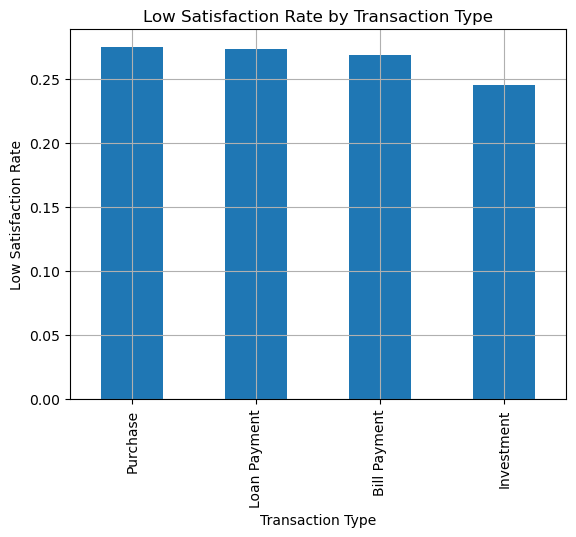

No product key found (e.g., Product_ID or Product_Name). Skipping product analysis.


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

df = final_df.copy()

# -----------------------------
# 1) Define "low" thresholds (adjust if your instructor uses different cutoffs)
# -----------------------------
LOW_SAT = 3          # low satisfaction if <= 3 (for 1–10 scale)
DETRACTOR = 6        # NPS detractor if <= 6, passive 7–8, promoter 9–10

# Create flags (only if columns exist)
if "Satisfaction_Score" in df.columns:
    df["Low_Satisfaction_Flag"] = (df["Satisfaction_Score"] <= LOW_SAT).astype(int)

if "Likelihood_to_Recommend" in df.columns:
    df["Detractor_Flag"] = (df["Likelihood_to_Recommend"] <= DETRACTOR).astype(int)
    df["NPS_Group"] = pd.cut(
        df["Likelihood_to_Recommend"],
        bins=[-0.1, 6, 8, 10],
        labels=["Detractor", "Passive", "Promoter"]
    )

# -----------------------------
# 2) Analyze by Transaction_Type
# -----------------------------
if "Transaction_Type" in df.columns:
    cols_needed = ["Transaction_Type"]
    if "Low_Satisfaction_Flag" in df.columns: cols_needed.append("Low_Satisfaction_Flag")
    if "Detractor_Flag" in df.columns: cols_needed.append("Detractor_Flag")
    if "Satisfaction_Score" in df.columns: cols_needed.append("Satisfaction_Score")
    if "Likelihood_to_Recommend" in df.columns: cols_needed.append("Likelihood_to_Recommend")
    if "Transaction_Amount" in df.columns: cols_needed.append("Transaction_Amount")

    g = df[cols_needed].groupby("Transaction_Type")

    summary_type = pd.DataFrame({
        "Tx_Count": g.size()
    })

    if "Satisfaction_Score" in cols_needed:
        summary_type["Avg_Satisfaction"] = g["Satisfaction_Score"].mean()

    if "Likelihood_to_Recommend" in cols_needed:
        summary_type["Avg_Recommend"] = g["Likelihood_to_Recommend"].mean()

    if "Low_Satisfaction_Flag" in cols_needed:
        summary_type["Low_Sat_Rate"] = g["Low_Satisfaction_Flag"].mean()

    if "Detractor_Flag" in cols_needed:
        summary_type["Detractor_Rate"] = g["Detractor_Flag"].mean()

    if "Transaction_Amount" in cols_needed:
        summary_type["Avg_Amount"] = g["Transaction_Amount"].mean()

    summary_type = summary_type.sort_values("Tx_Count", ascending=False)

    print("\n=== Transaction_Type Summary ===")
    display(summary_type)

    # Plot low satisfaction rate by type (if exists)
    if "Low_Sat_Rate" in summary_type.columns:
        summary_type_sorted = summary_type.sort_values("Low_Sat_Rate", ascending=False)
        summary_type_sorted["Low_Sat_Rate"].plot(kind="bar")
        plt.title("Low Satisfaction Rate by Transaction Type")
        plt.xlabel("Transaction Type")
        plt.ylabel("Low Satisfaction Rate")
        plt.grid(True)
        plt.show()
else:
    print("No Transaction_Type column found. Skipping transaction-type analysis.")

# -----------------------------
# 3) Analyze by Product (if you have a product key)
# -----------------------------
product_key = None
for k in ["Product_ID", "Product_Name", "Product", "Item_Name", "SKU"]:
    if k in df.columns:
        product_key = k
        break

MIN_TX = 20  # minimum transactions for a product to be considered (prevents noise)

if product_key:
    cols_needed = [product_key]
    if "Low_Satisfaction_Flag" in df.columns: cols_needed.append("Low_Satisfaction_Flag")
    if "Detractor_Flag" in df.columns: cols_needed.append("Detractor_Flag")
    if "Satisfaction_Score" in df.columns: cols_needed.append("Satisfaction_Score")
    if "Likelihood_to_Recommend" in df.columns: cols_needed.append("Likelihood_to_Recommend")
    if "Transaction_Amount" in df.columns: cols_needed.append("Transaction_Amount")

    g = df[cols_needed].groupby(product_key)

    summary_prod = pd.DataFrame({
        "Tx_Count": g.size()
    })

    if "Satisfaction_Score" in cols_needed:
        summary_prod["Avg_Satisfaction"] = g["Satisfaction_Score"].mean()

    if "Likelihood_to_Recommend" in cols_needed:
        summary_prod["Avg_Recommend"] = g["Likelihood_to_Recommend"].mean()

    if "Low_Satisfaction_Flag" in cols_needed:
        summary_prod["Low_Sat_Rate"] = g["Low_Satisfaction_Flag"].mean()

    if "Detractor_Flag" in cols_needed:
        summary_prod["Detractor_Rate"] = g["Detractor_Flag"].mean()

    if "Transaction_Amount" in cols_needed:
        summary_prod["Avg_Amount"] = g["Transaction_Amount"].mean()

    # filter to products with enough volume
    summary_prod = summary_prod[summary_prod["Tx_Count"] >= MIN_TX]

    print(f"\n=== Product Summary (min {MIN_TX} transactions) using key: {product_key} ===")
    display(summary_prod.sort_values("Low_Sat_Rate", ascending=False).head(20))

    # Plot top 15 worst products by low satisfaction rate
    if "Low_Sat_Rate" in summary_prod.columns and len(summary_prod) > 0:
        worst = summary_prod.sort_values("Low_Sat_Rate", ascending=False).head(15)
        worst["Low_Sat_Rate"].plot(kind="bar")
        plt.title(f"Top 15 Worst Products by Low Satisfaction Rate (min {MIN_TX} tx)")
        plt.xlabel(product_key)
        plt.ylabel("Low Satisfaction Rate")
        plt.grid(True)
        plt.show()

else:
    print("No product key found (e.g., Product_ID or Product_Name). Skipping product analysis.")

# -----------------------------
# 4) Optional: Combo view (Product x Transaction_Type) if both exist
# -----------------------------
if product_key and "Transaction_Type" in df.columns and "Low_Satisfaction_Flag" in df.columns:
    combo = (
        df.groupby(["Transaction_Type", product_key])["Low_Satisfaction_Flag"]
          .agg(["count", "mean"])
          .rename(columns={"count": "Tx_Count", "mean": "Low_Sat_Rate"})
          .reset_index()
    )
    combo = combo[combo["Tx_Count"] >= MIN_TX]
    print(f"\n=== Worst combinations (Transaction_Type x Product) min {MIN_TX} tx ===")
    display(combo.sort_values("Low_Sat_Rate", ascending=False).head(25))
